# Create ACS Index and Azure SQL Database for Avatar Demo
Use this notebook to create an Azure Cognitive Search Index and an Azure SQL Database and populate demo content for the Avatar outdoor shop application.  

Ensure that you have the the Microsoft ODBC driver for SQL Server installed. Here are the instructions for Linux based systems:  
https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/installing-the-microsoft-odbc-driver-for-sql-server?view=sql-server-ver16&tabs=ubuntu18-install%2Calpine17-install%2Cdebian8-install%2Credhat7-13-install%2Crhel7-offline#18


## Setup

In [1]:
# Install the required libraries
%pip install azure-search-documents==11.4.0b6 openai==0.28.1 tenacity pyodbc

# Install library for Azure Authentication
%pip install azure-identity azure-storage-blob

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json  
import pandas as pd

import pyodbc
import requests
import inspect

import openai  
from tenacity import retry, wait_random_exponential, stop_after_attempt  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SearchField,  
    SemanticSettings,  
    VectorSearch,  
    VectorSearchAlgorithmConfiguration,  
)  

You need to have the following settings for your Azure resources defined in the `local.settings.json` file in the __api__ subfolder to populate the demo content for the outdoor app:

In [3]:
#%pwd
#!cd c:/users/chihengchou/downloads/work/work/gen-cv-forked/gen-cv/avatar/interactive
%cd c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - aitour\\gen-cv\\avatar\\interactive
%pwd

c:\Users\chihengchou\Downloads\work\work\gen-cv-forked - aitour\gen-cv\avatar\interactive


'c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - aitour\\gen-cv\\avatar\\interactive'

In [4]:
# Load JSON file
with open('./api/local.settings.json', 'r') as file:
    data = json.load(file)

# Azure Cognitive Search
service_endpoint = data["Values"]["AZURE_SEARCH_ENDPOINT"]
key = data["Values"]["AZURE_SEARCH_API_KEY"]
index_name = data["Values"]["AZURE_SEARCH_INDEX"]

# Azure OpenAI
openai.api_type = "azure"
openai.api_key = data["Values"]["AZURE_OPENAI_API_KEY"]
openai.api_base = data["Values"]["AZURE_OPENAI_ENDPOINT"]
openai.api_version = data["Values"]["AZURE_OPENAI_API_VERSION"]
AOAI_embeddings_deployment = data["Values"]["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"]


## Create Cognitive Search Index
First, we create a new Index with demo data to the Cognitive Search service that you have deployed manually.

In [28]:
credential = AzureKeyCredential(key)

# csv原始資料需要去掉/n
df = pd.read_csv('data/products_cs_index.csv', dtype={'id': str})

# display(df.head())
display(df.tail())
input_data = df.to_dict(orient='records')

,id,content,product_image_file
2,13,'體驗 Microsoft 365 Copilot 對於 PM 的一天應用: 對於 PM ...,12.png
3,14,'體驗 Microsoft 365 Copilot Agent的應用: 使用 AI 的 A...,12.png
4,15,'微軟的 Microsoft Copilot + PC商務版: 各位來賓大家好，今天很高興...,15.png
5,16,'微軟 Teams 即時口譯介紹: 這是我們的AI即時口譯功能，如同長官在2月份看到的de...,16.png
6,17,'推動企業 AI 發展 AI as a Service正式啟動: 四月正式開張啟用。 優化...,17.png


In [29]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def generate_embeddings(text):
    response = openai.Embedding.create(
        input=text, engine=AOAI_embeddings_deployment)
    embeddings = response['data'][0]['embedding']
    return embeddings

In [30]:
# Generate embeddings for title and content fields
for item in input_data:
    content = item['content']
    content_embeddings = generate_embeddings(content)
    item['content_vector'] = content_embeddings

In [31]:
# Output embeddings to docVectors.json file
with open("./data/product-catalog-vectors.json", "w") as f:
    json.dump(input_data, f)

In [32]:
# Delete ACS index if it exists
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

try:
    if index_client.get_index(index_name):
        print('Deleting existing index...')
        index_client.delete_index(index_name)

except:
    print('Index does not exist. No need to delete it.')

Deleting existing index...


In [33]:
# Create a search index
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="content", type=SearchFieldDataType.String),
    SearchField(name="content_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                 searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SimpleField(name="product_image_file", type=SearchFieldDataType.String),
]

vector_search = VectorSearch(
    algorithm_configurations=[
        VectorSearchAlgorithmConfiguration(
            name="my-vector-config",
            kind="hnsw",
            hnsw_parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine"
            }
        )
    ]
)

index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 liteontour created


In [34]:
# Upload documents to the index
with open("./data/product-catalog-vectors.json", 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)  
print(f"Uploaded {len(documents)} documents") 

Uploaded 7 documents


## Perform Test Queries
We are performing a few test queries against the Cognitive Search index. If successful, it should display outdoor product information and images.

In [35]:
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
fields_of_interest = ["id", "content", "product_image_file"]

Results:
<iterator object azure.core.paging.ItemPaged at 0x147c01baed0>
ID: 11
Score: 0.81943196
Content:  '這場活動帶來 9 大精彩Copilot應用體驗活動，讓您親身體驗 AI 如何優化數位工作環境.體驗活動包括了: #1 AI 助理語音互動應用 透過 AI 助理 Welcome Avatar，體驗智慧化語音導覽，還可應用於 Smart Order 點餐，讓 AI 成為您的貼心助手！#2 同仁的一天 跟隨 Copilot 深入 RD & PM 團隊，見證 AI 如何提升團隊溝通、任務管理，打造更高效的工作環境！#3 Copilot Agent 探索 客製化 AI 助理，學習如何讓 Copilot 幫助您自動化日常工作，提升決策效率！#4 AI App Store AI 應用IT 團隊不容錯過！透過 AI App Store 輕鬆部署 AI 應用，零安裝立即上手，打造企業專屬 AI 解決方案！#5 AI as a Service整合 AI 算法與訓練平台，自動化管理 AI 資源，打造 AI 計算新時代，助力企業 AI 戰略佈局！#6 Teams AI 即時口譯語言不再是溝通障礙！模擬聲調、即時翻譯，讓會議不僅有字幕，更能流暢對話，促進全球協作！#7 即時翻譯頭戴顯示器智慧鏡結合 Teams AI 翻譯，開啟 沉浸式跨語言會議體驗，無論語言如何變換，都能輕鬆交流！#8 Surface Copilot + PCAI PC 結合 Copilot，打造 智慧高效工作體驗，讓您的生產力再進化！#9 Logitech AI 會議解決方案'
Image file: 11.png

image_url:  https://paytonavatarimage.blob.core.windows.net/liteon-images/11.png


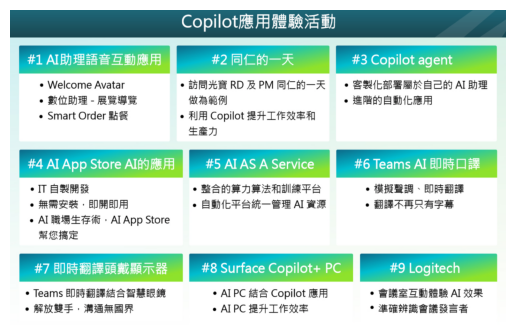

ID: 13
Score: 0.80573636
Content:  '體驗 Microsoft 365 Copilot 對於 PM 的一天應用: 對於 PM 產品管理同仁來說，Copilot 可以幫助他們查看行事曆中的重要行程，檢查電子郵件中的緊急資訊，並確定當天任務的優先順序。在追蹤工作進度時，Copilot 能夠協助整理專案事項資料，分析當前規劃專案相關問題。此外，Copilot 還能幫助PM 同仁進行跨國跨區協作，快速回覆客戶問題，並發佈資訊與 RD 同步'
Image file: 12.png

image_url:  https://paytonavatarimage.blob.core.windows.net/liteon-images/12.png


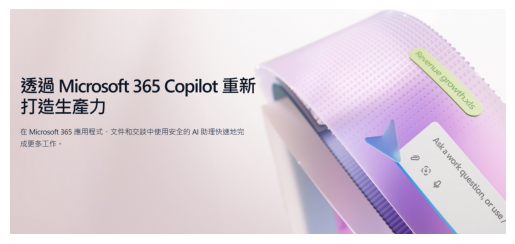

ID: 12
Score: 0.8010717
Content:  '體驗 Microsoft 365 Copilot 對於 RD 的一天應用: 對於 RD 研發人員來說，Copilot 可以幫助他們安排工作時程，查看行事曆中的重要行程，並檢查電子郵件中的緊急資訊。在進行工作會議時，Copilot 能夠整理過去24小時的會議重點，列出待辦事項，並標示需要回顧的會議。此外，Copilot 還能協助分析整理資料，快速回覆客戶問題，並產出工作報告簡報草禍。'
Image file: 12.png

image_url:  https://paytonavatarimage.blob.core.windows.net/liteon-images/12.png


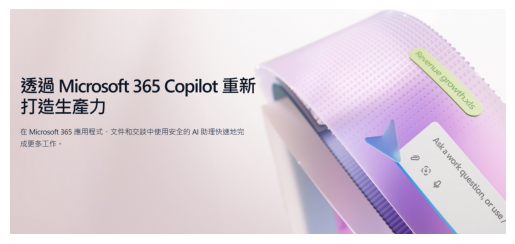

In [38]:
# Test code for using BlobServiceClient
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from PIL import Image

def display_image_from_blob(image_file):
    # Use public blob storage URL to display image
    image_url = (
        "https://paytonavatarimage.blob.core.windows.net/liteon-images/" + image_file
    )
    print("image_url: ", image_url)
    response = requests.get(image_url)
    blob_data = response.content

    img = plt.imread(BytesIO(blob_data))
    plt.imshow(img)
    plt.axis('off')  # No axes for this plot
    plt.show()

def print_results(results):
  print("Results:")
  print(results)
  for result in results:
    print(f"ID: {result['id']}")
    print(f"Score: {result['@search.score']}")
    print(f"Content: {result['content']}")  
    print(f"Image file: {result['product_image_file']}\n")
    display_image_from_blob(result['product_image_file'])

# Pure Vector Search
query = "請介紹今日的活動"
#query = "請介紹Teams 即時口譯"
#query = "請問Copilot議題, 有哪些議程?"


results = search_client.search(  
    search_text=None,  
    vector=generate_embeddings(query), top_k=3,  
    vector_fields="content_vector",
    select= fields_of_interest
)  
print_results(results)